# Bigbrotr Database Data Overview

In [229]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src")

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

from bigbrotr import Bigbrotr
from event import Event
from relay import Relay
from relay_metadata import RelayMetadata
import utils
import pandas as pd
from datetime import datetime
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
import numpy as np

DB_HOST = 'localhost'
DB_PORT =5432
DB_USER = 'admin'
DB_PASSWORD = 'admin'
DB_NAME = 'bigbrotr'

bigbrotr = Bigbrotr(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

bigbrotr.connect()

## Database Schema

In [22]:
def get_schema_overview(conn):
    q = '''
    SELECT table_name, column_name, data_type
    FROM information_schema.columns
    WHERE table_schema = 'public'
    ORDER BY table_name, ordinal_position;
    '''
    return pd.read_sql(q, conn)

schema_df = get_schema_overview(bigbrotr.conn)
for table_name in schema_df['table_name'].unique():
    df = schema_df[schema_df['table_name'] == table_name].drop(columns='table_name')
    display(table_name.capitalize())
    print(df.to_markdown(index=False))
    print("\n")

'Events'

| column_name   | data_type   |
|:--------------|:------------|
| id            | character   |
| pubkey        | character   |
| created_at    | bigint      |
| kind          | integer     |
| tags          | jsonb       |
| content       | text        |
| sig           | character   |




'Events_relays'

| column_name   | data_type   |
|:--------------|:------------|
| event_id      | character   |
| relay_url     | text        |
| seen_at       | bigint      |




'Relay_metadata'

| column_name        | data_type   |
|:-------------------|:------------|
| relay_url          | text        |
| generated_at       | bigint      |
| connection_success | boolean     |
| nip11_success      | boolean     |
| openable           | boolean     |
| readable           | boolean     |
| writable           | boolean     |
| rtt_open           | integer     |
| rtt_read           | integer     |
| rtt_write          | integer     |
| name               | text        |
| description        | text        |
| banner             | text        |
| icon               | text        |
| pubkey             | text        |
| contact            | text        |
| supported_nips     | jsonb       |
| software           | text        |
| version            | text        |
| privacy_policy     | text        |
| terms_of_service   | text        |
| limitation         | jsonb       |
| extra_fields       | jsonb       |




'Relays'

| column_name   | data_type   |
|:--------------|:------------|
| url           | text        |
| network       | text        |
| inserted_at   | bigint      |




## Row Counts per Table


In [28]:
def get_row_counts(conn):
    q = '''
    SELECT relname as table, n_live_tup as row_count
    FROM pg_stat_user_tables
    ORDER BY n_live_tup DESC;
    '''
    return pd.read_sql(q, conn)

row_counts = get_row_counts(bigbrotr.conn)
display(row_counts)

,table,row_count
0,events_relays,11360328
1,events,6385152
2,relays,8865
3,relay_metadata,775


## Events Table Overview
### Distribution of Event Creation Times


In [ ]:
events = pd.read_sql('SELECT id, pubkey, created_at, kind, tags, content, sig FROM events', conn)
events['created_at_dt'] = pd.to_datetime(events['created_at'], unit='s')
events.set_index('created_at_dt', inplace=True)
events['kind'] = events['kind'].astype(str)
events.resample('D').size().plot(title='Events per Day')
plt.ylabel('Number of Events')
plt.show()


/tmp/ipykernel_49048/1986816916.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events = pd.read_sql('SELECT id, pubkey, created_at, kind, tags, content, sig FROM events', conn)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x708d70b563f0>>
Traceback (most recent call last):
  File "/home/vincenzo/Documents/GitHub/bigbrotr/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


### Distribution of Event Kinds


In [ ]:
events['kind'].value_counts().sort_index().plot(kind='bar', title='Event Kind Distribution')
plt.xlabel('Kind')
plt.ylabel('Count')
plt.show()


### Top Pubkeys by Event Count


In [ ]:
events['pubkey'].value_counts().head(20).plot(kind='bar', title='Top 20 Pubkeys by Event Count')
plt.xlabel('Pubkey')
plt.ylabel('Event Count')
plt.show()


## Relays Table Overview
### Distribution of Relay Networks


In [191]:
relays_w_metadata = pd.read_sql(
    '''
    SELECT DISTINCT ON (relay_url) relay_url
    FROM relay_metadata
    ''', bigbrotr.conn
)
relays = pd.read_sql('SELECT url, network FROM relays', bigbrotr.conn)
relays['metadata'] = relays['url'].isin(relays_w_metadata['relay_url'])
with_metadata_count = relays['metadata'].sum()
total_relays = relays.shape[0]
print(f"Total relays: {total_relays}, with metadata: {with_metadata_count} ({with_metadata_count/total_relays:.2%})")
print("Network distribution for relays with metadata:")
tmp = relays[relays['metadata']]['network'].value_counts().reset_index()
tmp['perc'] = tmp['count'] / tmp['count'].sum() * 100
for _, row in tmp.iterrows():
    print(f"- {row['network']}: {row['count']} ({row['perc']:.2f}%)")

Total relays: 8865, with metadata: 543 (6.13%)
Network distribution for relays with metadata:
- clearnet: 502 (92.45%)
- tor: 41 (7.55%)


In [233]:
relay_metadata = pd.read_sql(
    '''
    SELECT *
    FROM relay_metadata
    ''', bigbrotr.conn
)
relay_metadata = pd.merge(relay_metadata, relays.filter(['url', 'network']).rename(columns={'url': 'relay_url'}), how='left')

In [234]:
tmp = relay_metadata.copy()
tmp['date'] = pd.to_datetime(tmp['generated_at'], unit='s').dt.date
tmp_daily = tmp.sort_values(['relay_url', 'generated_at']).drop_duplicates(subset=['relay_url', 'date'])
tmp_daily = tmp_daily.set_index(['relay_url', 'date'])

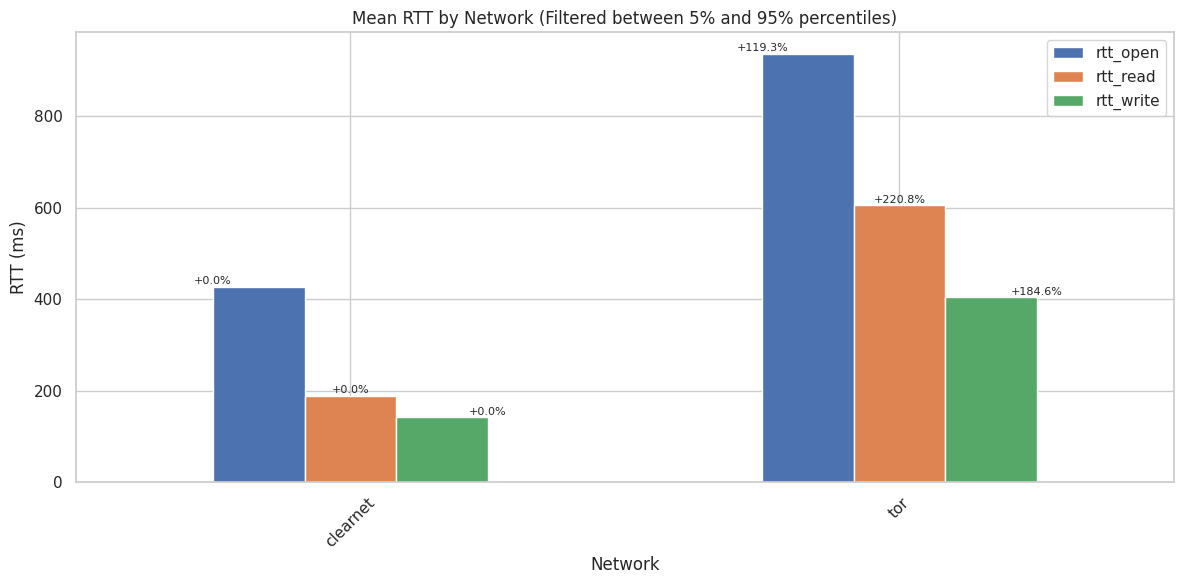

In [196]:
def plot_mean_rtt_percentile_filter(df, rtt_columns, lower_pct=0.05, upper_pct=0.95):
    """
    df: dataframe originale con 'network' e colonne RTT
    rtt_columns: lista colonne RTT su cui filtrare outlier con percentili
    lower_pct: percentile inferiore (es. 0.05 = 5%)
    upper_pct: percentile superiore (es. 0.95 = 95%)
    """
    df_clean = df.dropna(subset=rtt_columns).copy()
    
    for col in rtt_columns:
        low_val = df_clean[col].quantile(lower_pct)
        high_val = df_clean[col].quantile(upper_pct)
        df_clean = df_clean[(df_clean[col] >= low_val) & (df_clean[col] <= high_val)]
    
    mean_rtt = df_clean.groupby('network')[rtt_columns].mean()
    best_rtt = mean_rtt.min()
    percent_diff = ((mean_rtt - best_rtt) / best_rtt * 100).round(1)
    
    ax = mean_rtt.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Mean RTT by Network (Filtered between {int(lower_pct*100)}% and {int(upper_pct*100)}% percentiles)')
    plt.ylabel('RTT (ms)')
    plt.xlabel('Network')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Etichette % sopra barre
    for i, col in enumerate(mean_rtt.columns):
        for j, val in enumerate(mean_rtt[col]):
            pct = percent_diff.iloc[j, i]
            ax.text(j + i*0.25 - 0.25, val + 1, f'+{pct}%', ha='center', va='bottom', fontsize=8)
    
    plt.show()

# Uso:
df_tmp = tmp_daily.reset_index()
plot_mean_rtt_percentile_filter(df_tmp, ['rtt_open', 'rtt_read', 'rtt_write'], lower_pct=0.05, upper_pct=0.95)

In [197]:
metrics = ['connection_success', 'nip11_success', 'readable', 'writable', 'openable']
networks = ['clearnet', 'tor', 'all']

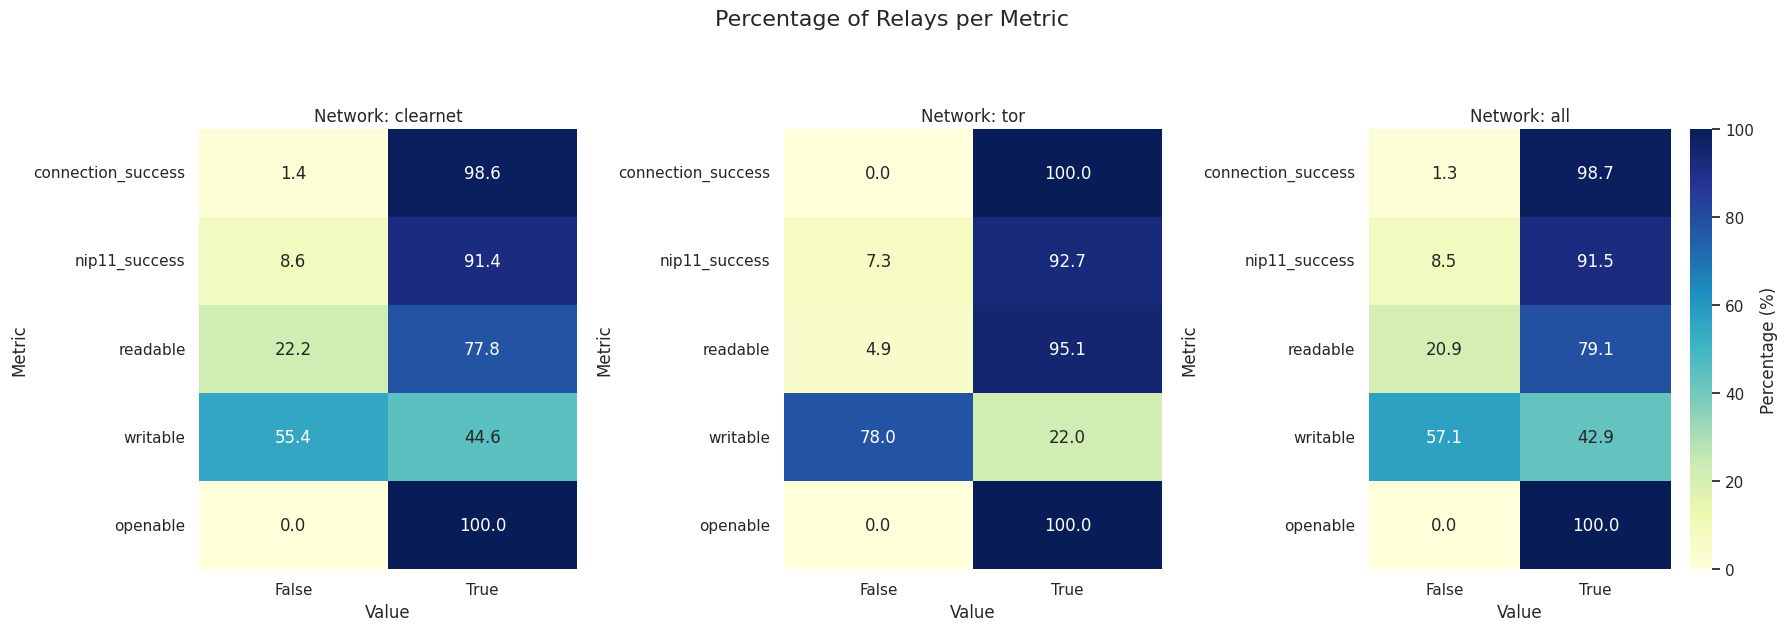

In [198]:
# Prepara i dati heatmap in un dizionario (simula il calcolo precedente)
heatmaps_data = {}

for network in networks:
    if network == 'all':
        tmp_network = tmp_daily
    else:
        tmp_network = tmp_daily[tmp_daily['network'] == network]

    def safe_mode(series):
        modes = series.mode()
        if modes.empty:
            return None
        else:
            return modes.iloc[0]

    mode_df = tmp_network.groupby(level=0)[metrics].agg(safe_mode)

    mode_counts = pd.DataFrame({
        col: mode_df[col].value_counts() for col in metrics
    }).fillna(0).astype(int)

    mode_percent = mode_counts.div(mode_counts.sum(axis=0), axis=1) * 100

    heatmaps_data[network] = mode_percent.T

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Percentage of Relays per Metric", fontsize=16, y=1.05)

for i, network in enumerate(networks):
    sns.heatmap(
        heatmaps_data[network],
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        cbar=(i == 2),
        ax=axs[i],
        cbar_kws={'label': 'Percentage (%)'}
    )
    axs[i].set_title(f"Network: {network}", fontsize=12)
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Metric")
    axs[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

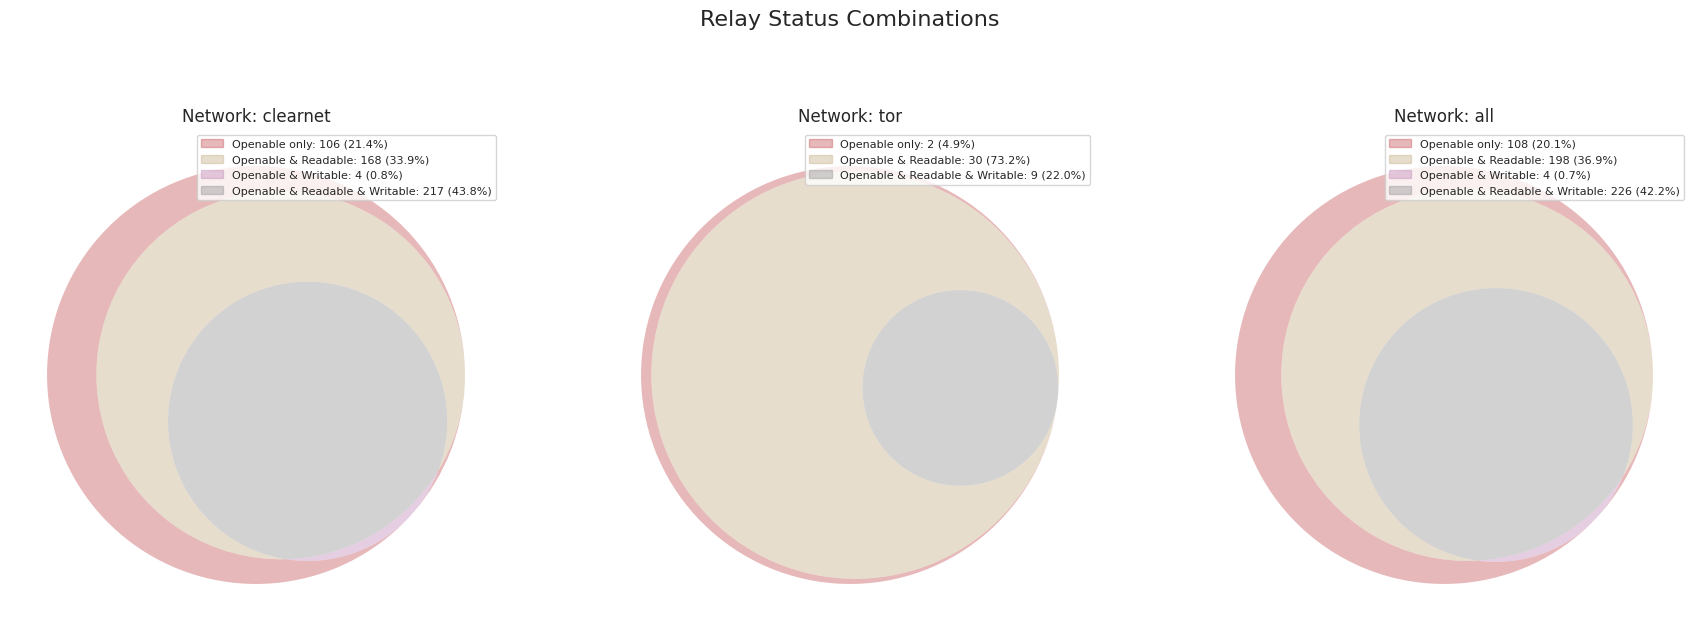

In [199]:
subset_labels = {
    '100': 'Openable only',
    '010': 'Readable only',
    '001': 'Writable only',
    '110': 'Openable & Readable',
    '101': 'Openable & Writable',
    '011': 'Readable & Writable',
    '111': 'Openable & Readable & Writable',
}

venn_sets = {}

# Prepara i set per ogni network
for network in networks:
    if network == 'all':
        tmp_network = tmp_daily
    else:
        tmp_network = tmp_daily[tmp_daily['network'] == network]

    def safe_mode(series):
        modes = series.mode()
        if modes.empty:
            return None
        else:
            return modes.iloc[0]

    mode_df = tmp_network.groupby(level=0)[['openable', 'readable', 'writable']].agg(safe_mode)

    set_openable = set(mode_df[mode_df['openable'] == True].index)
    set_readable = set(mode_df[mode_df['readable'] == True].index)
    set_writable = set(mode_df[mode_df['writable'] == True].index)

    venn_sets[network] = (set_openable, set_readable, set_writable)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Relay Status Combinations", fontsize=16, y=1.05)

for i, network in enumerate(networks):
    set_openable, set_readable, set_writable = venn_sets[network]
    v = venn3([set_openable, set_readable, set_writable], ax=axs[i])

    # Nascondi nomi e numeri sui cerchi
    for text in v.set_labels:
        if text:
            text.set_visible(False)
    for subset_id in subset_labels.keys():
        label = v.get_label_by_id(subset_id)
        if label:
            label.set_text('')

    total_relays = len(set_openable.union(set_readable).union(set_writable))
    sets = [set_openable, set_readable, set_writable]

    patches = []
    for subset_id, label_text in subset_labels.items():
        patch = v.get_patch_by_id(subset_id)
        if patch:
            included_sets = [subset_id[j] == '1' for j in range(3)]

            selected = sets[0] if included_sets[0] else set()
            for j in range(1, 3):
                if included_sets[j]:
                    if selected:
                        selected = selected.intersection(sets[j])
                    else:
                        selected = sets[j]
            for j in range(3):
                if not included_sets[j]:
                    selected = selected.difference(sets[j])

            count = len(selected)
            percent = (count / total_relays * 100) if total_relays > 0 else 0
            label_with_count = f"{label_text}: {count} ({percent:.1f}%)"
            patches.append(mpatches.Patch(color=patch.get_facecolor(), label=label_with_count))

    axs[i].legend(handles=patches, loc='upper right', fontsize=8)
    axs[i].set_title(f"Network: {network}", fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [239]:
nip11_cols = ['name', 'description', 'banner', 'icon', 'pubkey', 'contact', 'supported_nips', 'software', 'version', 'privacy_policy', 'terms_of_service', 'limitation', 'extra_fields']
# compute of aech relay the mode value of nip11 columns considering that supported_nips is a list and limitations and extra_fielsds are dictionary

import pandas as pd
from collections import Counter

def mode_of_series(series):
    """Calculate the mode (most frequent value) of a Series."""
    if series.empty:
        return None
    mode_series = series.mode()
    if mode_series.empty:
        return None
    return mode_series.iloc[0]

def mode_of_lists(series):
    tuples = series.apply(lambda x: tuple(x) if isinstance(x, list) else x)
    if tuples.empty:
        return []
    mode_series = tuples.mode()
    if mode_series.empty:
        return []
    mode_tuple = mode_series.iloc[0]
    return list(mode_tuple) if isinstance(mode_tuple, tuple) else mode_tuple

def mode_of_dicts(series):
    def dict_to_tuple(d):
        if isinstance(d, dict):
            return tuple(sorted(d.items()))
        return d
    tuples = series.apply(dict_to_tuple)
    if tuples.empty:
        return {}
    mode_series = tuples.mode()
    if mode_series.empty:
        return {}
    mode_tuple = mode_series.iloc[0]
    return dict(mode_tuple) if isinstance(mode_tuple, tuple) else mode_tuple

# Collect results for each relay_url
results = []

for relay_url, group in tmp_daily.groupby(level='relay_url'):
    row = {'relay_url': relay_url}
    for col in nip11_cols:
        if col not in group.columns:
            row[col] = None
            continue

        if col == 'supported_nips':
            row[col] = mode_of_lists(group[col])
        elif col in ['limitation', 'extra_fields']:
            row[col] = mode_of_dicts(group[col])
        else:
            row[col] = mode_of_series(group[col])
    results.append(row)

# Convert to DataFrame
nip11_modes_df = pd.DataFrame(results).set_index('relay_url')

nip11_modes_df['supported_nips'] = nip11_modes_df['supported_nips'].apply(lambda x: np.nan if x == [] else x)
nip11_modes_df['limitation'] = nip11_modes_df['limitation'].apply(lambda x: np.nan if x == {} else x)
nip11_modes_df['extra_fields'] = nip11_modes_df['extra_fields'].apply(lambda x: np.nan if x == {} else x)


# for each nip11 column, compute the percentage of relays that have a value
nip11_percentages = {}
for col in nip11_cols:
    if col not in nip11_modes_df.columns:
        continue
    total_relays = nip11_modes_df.shape[0]
    if total_relays == 0:
        nip11_percentages[col] = 0.0
    else:
        count_with_value = nip11_modes_df[col].notna().sum()
        nip11_percentages[col] = (count_with_value / total_relays) * 100
nip11_percentages_df = pd.DataFrame(nip11_percentages.items(), columns=['Column', 'Percentage'])
nip11_percentages_df = nip11_percentages_df.sort_values(by='Percentage', ascending=False)
nip11_percentages_df.reset_index(drop=True, inplace=True)
nip11_percentages_df.index += 1  # Start index from 1
nip11_percentages_df.index.name = 'Rank'
nip11_percentages_df['Percentage'] = nip11_percentages_df['Percentage'].round(2)
nip11_percentages_df['Percentage'] = nip11_percentages_df['Percentage'].astype(str) + '%'
nip11_percentages_df = nip11_percentages_df.rename(columns={'Column': 'NIP-11 Column'})
display(nip11_percentages_df)

,NIP-11 Column,Percentage
Rank,,
1,name,91.34%
2,software,91.16%
3,version,90.61%
4,description,82.14%
5,pubkey,68.51%
6,limitation,66.67%
7,extra_fields,59.12%
8,contact,56.35%
9,icon,27.26%


In [238]:
d = {}
for _, row in nip11_modes_df.iterrows():
    limitation = row['limitation']
    if isinstance(limitation, dict):
        for key in limitation:
            if key not in d:
                d[key] = 1
            else:
                d[key] += 1
d_df = pd.DataFrame(d.items(), columns=['Limitation', '# Relays'])
d_df = d_df.sort_values(by='# Relays', ascending=False)
d_df.reset_index(drop=True, inplace=True)
d_df.index += 1  # Start index from 1
d_df.index.name = 'Rank'
d_df['# Relays'] = d_df['# Relays'].astype(str)
d_df = d_df.rename(columns={'Limitation': 'Limitation Type'})
display(d_df)

,Limitation Type,# Relays
Rank,,
1,payment_required,261
2,max_message_length,192
3,max_limit,191
4,max_subscriptions,188
5,restricted_writes,165
6,auth_required,116
7,max_event_tags,100
8,max_filters,87
9,min_pow_difficulty,87


## Events_Relays Table Overview
### Distribution of Seen_at Timestamps


In [226]:
events_relays = pd.read_sql('SELECT event_id, relay_url, seen_at FROM events_relays', conn)
events_relays['seen_at_dt'] = pd.to_datetime(events_relays['seen_at'], unit='s')
events_relays.set_index('seen_at_dt', inplace=True)
events_relays.resample('D').size().plot(title='Events Seen per Day (across relays)')
plt.ylabel('Number of Events Seen')
plt.show()


NameError: name 'conn' is not defined

### Top Relays by Event Count


In [ ]:
events_relays['relay_url'].value_counts().head(20).plot(kind='bar', title='Top 20 Relays by Event Seen Count')
plt.xlabel('Relay URL')
plt.ylabel('Event Seen Count')
plt.show()


## Relay_Metadata Table Overview
### Connection and NIP-11 Success Rates


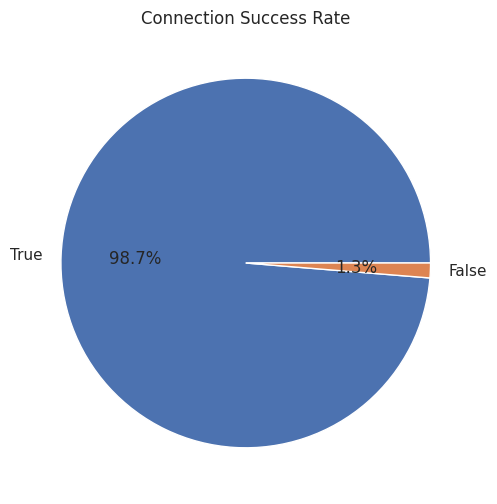

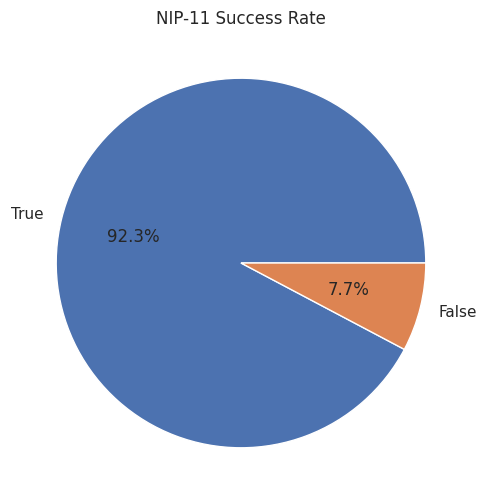

In [31]:
relay_metadata = pd.read_sql('SELECT * FROM relay_metadata', bigbrotr.conn)
relay_metadata['connection_success'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Connection Success Rate')
plt.ylabel('')
plt.show()
relay_metadata['nip11_success'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='NIP-11 Success Rate')
plt.ylabel('')
plt.show()


### RTT Distributions (Open, Read, Write)


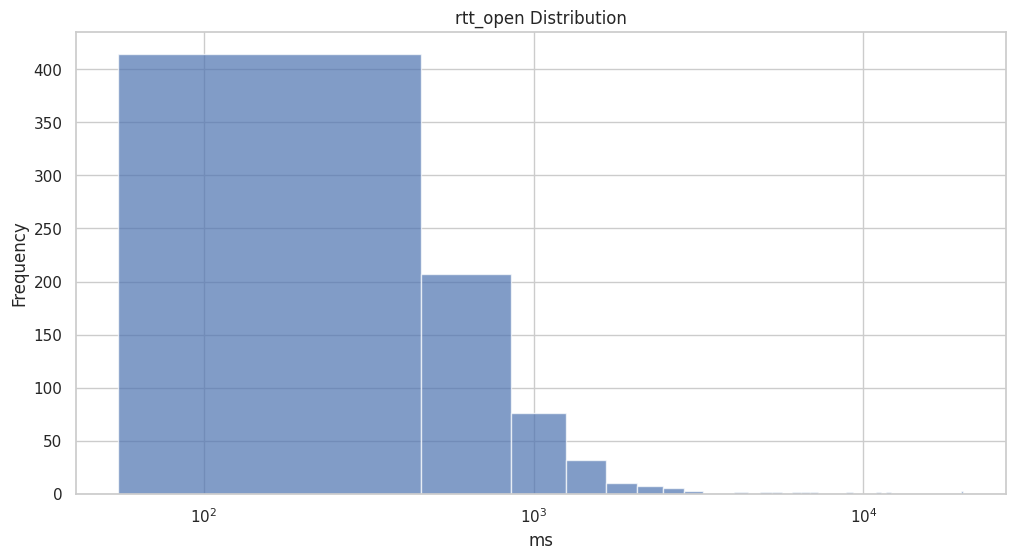

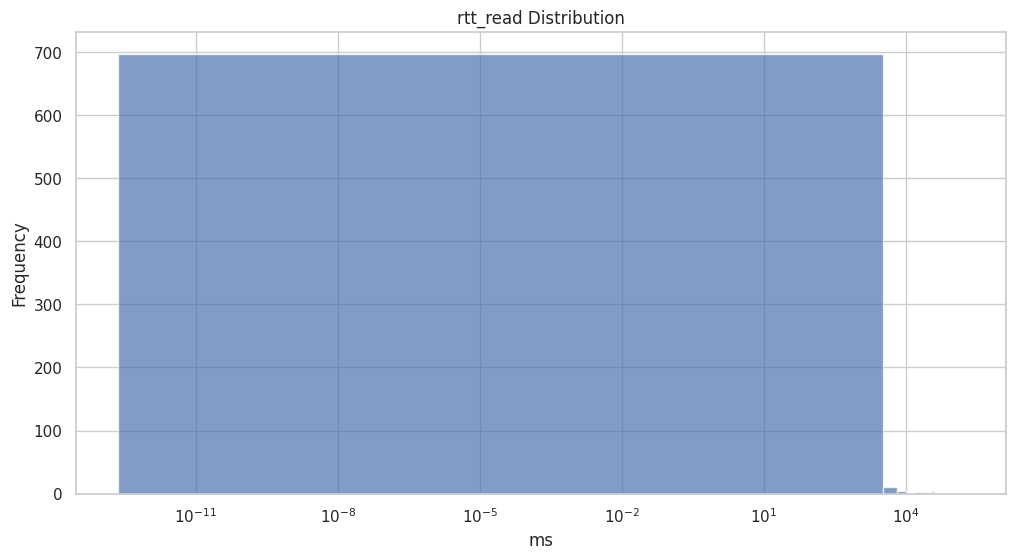

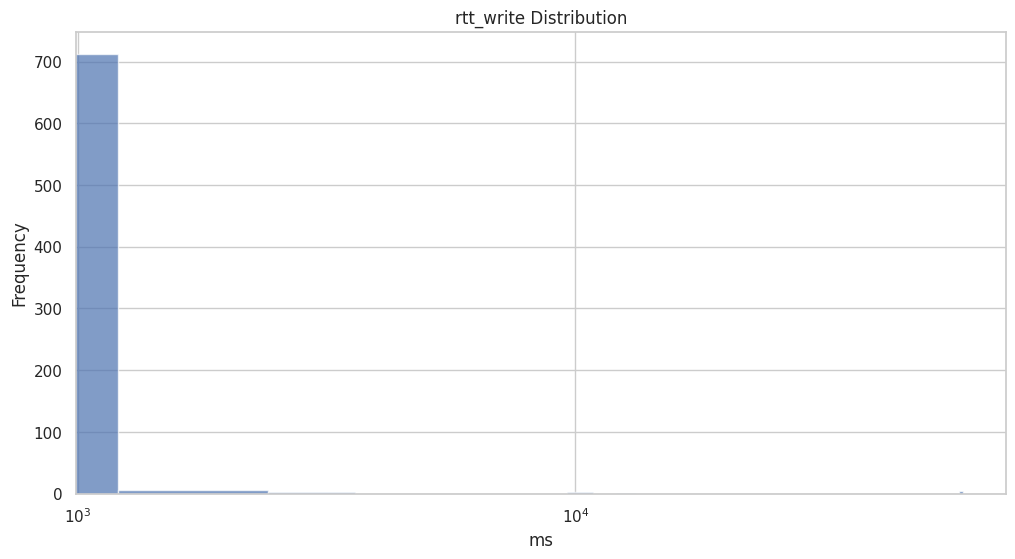

In [33]:
for col in ['rtt_open', 'rtt_read', 'rtt_write']:
    if col in relay_metadata.columns:
        relay_metadata[col].dropna().plot(kind='hist', bins=50, alpha=0.7, title=f'{col} Distribution')
        plt.xlabel('ms')
        plt.xscale('log')
        plt.show()

### Supported NIPs Distribution


In [34]:
import json
nip_counts = {}
for nips in relay_metadata['supported_nips'].dropna():
    try:
        nips_list = json.loads(nips) if isinstance(nips, str) else nips
        for nip in nips_list:
            nip_counts[nip] = nip_counts.get(nip, 0) + 1
    except Exception:
        continue
if nip_counts:
    pd.Series(nip_counts).sort_values(ascending=False).plot(kind='bar', title='Supported NIPs Distribution')
    plt.xlabel('NIP')
    plt.ylabel('Relay Count')
    plt.show()


### Software and Version Popularity


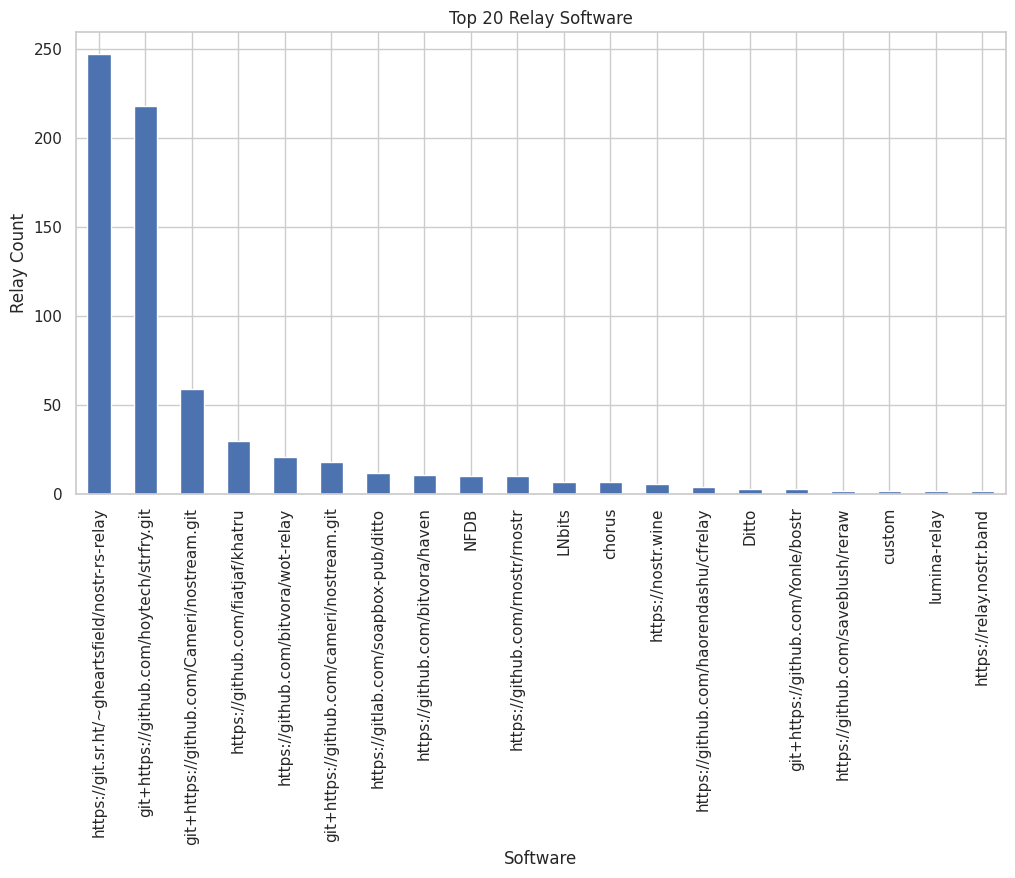

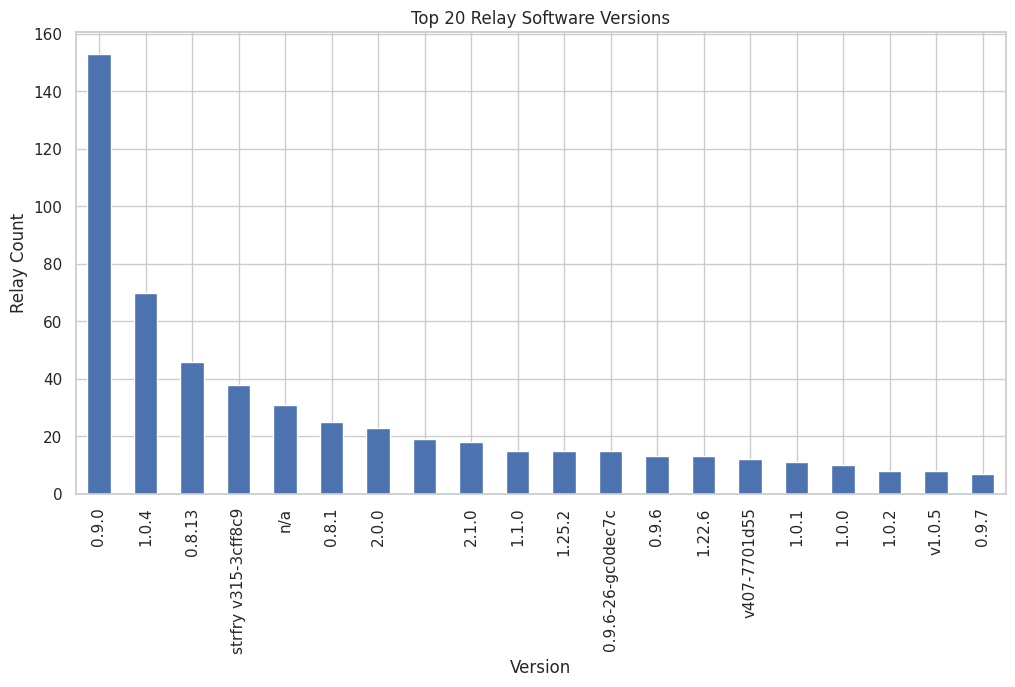

In [35]:
relay_metadata['software'].value_counts().head(20).plot(kind='bar', title='Top 20 Relay Software')
plt.xlabel('Software')
plt.ylabel('Relay Count')
plt.show()
relay_metadata['version'].value_counts().head(20).plot(kind='bar', title='Top 20 Relay Software Versions')
plt.xlabel('Version')
plt.ylabel('Relay Count')
plt.show()


### Openable, Readable, Writable Status


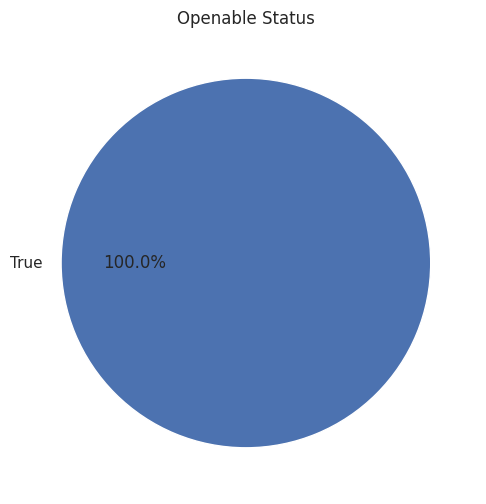

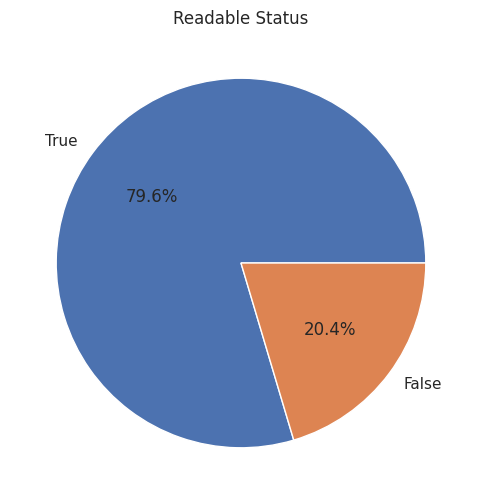

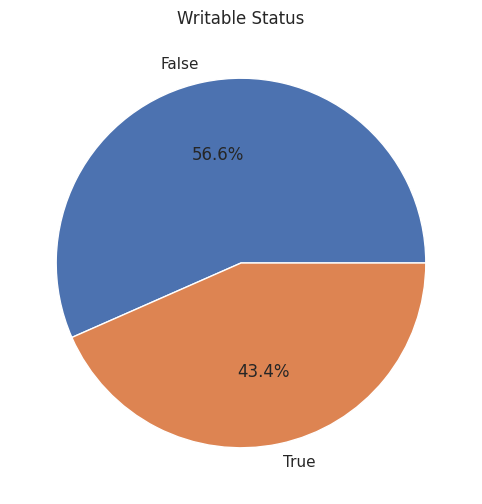

In [36]:
for col in ['openable', 'readable', 'writable']:
    if col in relay_metadata.columns:
        relay_metadata[col].value_counts().plot(kind='pie', autopct='%1.1f%%', title=f'{col.capitalize()} Status')
        plt.ylabel('')
        plt.show()


## Correlations and Advanced Analysis
### RTT vs. Connection Success


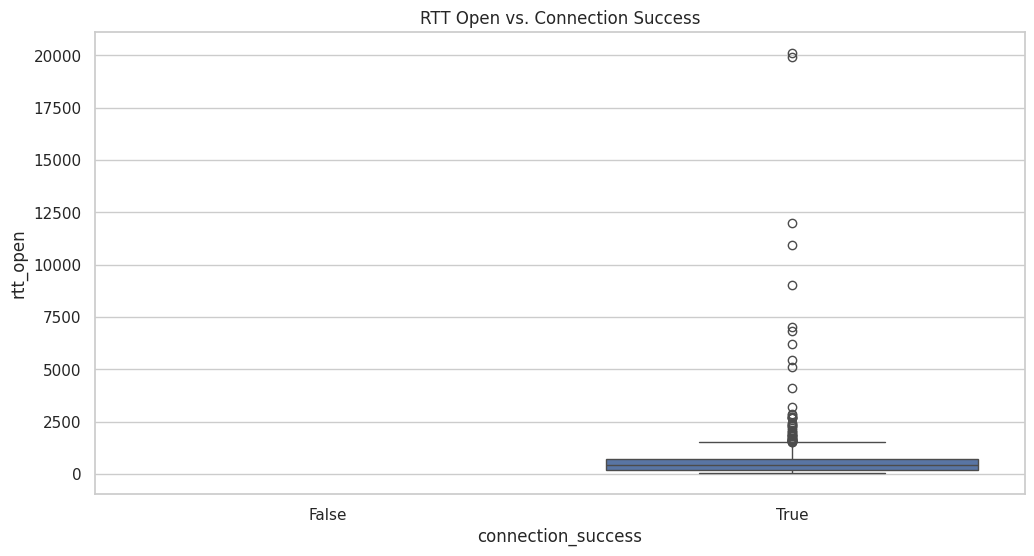

In [37]:
sns.boxplot(x='connection_success', y='rtt_open', data=relay_metadata)
plt.title('RTT Open vs. Connection Success')
plt.show()
